# Collaboration and Competition

---

In this notebook, we will try to teach a multi agent RL algorithm to play tennis. We will be using Unity ML-Agents to train the agents.

### 1. Start the Environment

In [1]:
# import the necessary packages
from unityagents import UnityEnvironment
import numpy as np
import torch
from agent.ppo import PPO
from collections import deque
from agent.trainer import Trainer
from agent.model import ActorCritic
import matplotlib.pyplot as plt

In [2]:
# instantiate the unity environment
env = UnityEnvironment(file_name="D:\learning\deep_reinforcement_learning_nanodegree\p3_collab-compet\Tennis_Windows_x86\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Code cell below prints some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Define interaction and training functions

``play_episode`` function plays a single episode on environment using the given ``agent``. If a ``trainer`` is provided, then it records the experience tuples in rollout buffer and executes an update when a batch is ready. If ``trainer`` is None, then the function runs in evaluation mode. Advantage of this approach is that we record experience data and make additional inference call only when we're training.

``train_agent`` function plays the episodes until the environment is solved. It also tracks the scores and outputs training statistics. 

In [5]:
def play_episode(env, brain_name, agent, trainer=None, max_t=1000):
    """play an episode and return the scores

    Args:
        env (UnityEnvironment): Unity 3D environment
        brain_name (String): Unity env brain name
        agent (object): Agent object
        trainer (object, optional): Training helper. Defaults to None.
        max_t (int, optional): Maximum time steps for the episode. Defaults to 1000.

    Returns:
        tuple(float): Mean and max score of the episode and the episode length
    """
    env_info = env.reset(train_mode=True if trainer else False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    for t in range(max_t):
        actions, action_log_probs, state_values = agent.act(states)
        env_info = env.step(actions)[brain_name]

        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += rewards                                   # update the score (for each agent)

        if trainer:
            trainer.step(states, actions, action_log_probs, rewards, state_values, dones)

        states = next_states
        if np.any(dones):
            break

    return np.max(scores), t


def train_agent(agent, env, brain_name, trainer, num_episodes=1000, max_t=1000):
    """Train the agent

    Args:
        agent (object): Agent object to train
        env (UnityEnvironment): Unity 3D environment
        brain_name (String): Unity env brain name
        trainer (object): Trainer object
        num_episodes (int, optional): Max number of episodes to try. Defaults to 1000.
        max_t (int, optional): Max length of each episode. Defaults to 1000.

    Returns:
        [type]: [description]
    """
    scores_history = []
    scores_100 = deque(maxlen=100)
    ep_lengths_100 = deque(maxlen=100)
    for i_episode in range(1, num_episodes+1):
        score, t = play_episode(env, brain_name, agent, trainer=trainer, max_t=max_t)
        scores_history.append(score)
        scores_100.append(score)
        ep_lengths_100.append(t)
        last_100_avg = '{:.2f}'.format(np.mean(scores_100)) if len(scores_100) == 100 else 'NA'
        last_100_t_avg = '{:.2f}'.format(np.mean(ep_lengths_100)) if len(ep_lengths_100) == 100 else 'NA'

        if(i_episode % 500 == 0):
            print('\nEpisode {}\taverage score: {}\taverage length: {:.2f}'.format(i_episode, last_100_avg, np.mean(ep_lengths_100)), end="")

        # if env is solved, break and save the model
        if len(scores_100) == 100 and np.mean(scores_100) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\taverage score: {:.2f}'.format(i_episode, np.mean(scores_100)))
            print('\nSaving agent...')
            agent.save('checkpoints/ppo_checkpoint_' + str(i_episode) + '.pth')
            break

    return scores_history

### Create instances and launch training
Next we define the agent and trainer objects and launch the training.

In [6]:
# set device to cpu or cuda
device = torch.device('cpu')

agent = PPO(ActorCritic, state_size, action_size, 1e-3, 1e-3, 0.99, device, K_epochs=4, eps_clip=0.1)
trainer = Trainer(agent, device=device, trajectory_length=1000, batch_size=100, tau=0.95)

In [7]:
# train the agent
history = train_agent(agent, env, brain_name, trainer, num_episodes=20000, max_t=2000)


Episode 500	average score: 0.03	average length: 19.70
Episode 1000	average score: 0.02	average length: 18.92
Episode 1500	average score: 0.02	average length: 18.41
Episode 2000	average score: 0.04	average length: 22.44
Episode 2500	average score: 0.05	average length: 24.28
Episode 3000	average score: 0.06	average length: 25.21
Episode 3500	average score: 0.06	average length: 25.65
Episode 4000	average score: 0.07	average length: 31.17
Episode 4500	average score: 0.07	average length: 27.73
Episode 5000	average score: 0.08	average length: 29.80
Episode 5500	average score: 0.08	average length: 30.39
Episode 6000	average score: 0.09	average length: 35.82
Episode 6500	average score: 0.08	average length: 31.46
Episode 7000	average score: 0.09	average length: 34.77
Episode 7500	average score: 0.10	average length: 38.78
Episode 8000	average score: 0.12	average length: 47.20
Episode 8500	average score: 0.13	average length: 52.33
Episode 9000	average score: 0.14	average length: 56.43
Episode 95

### Plot metrics

Text(0, 0.5, 'Score')

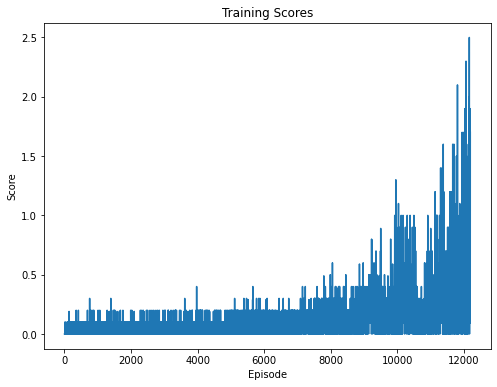

In [8]:
# plot the scores
plt.figure(figsize=(8,6))
plt.plot(history)
plt.title('Training Scores')
plt.xlabel('Episode')
plt.ylabel('Score')

Text(0.5, 1.0, 'Distribution Std')

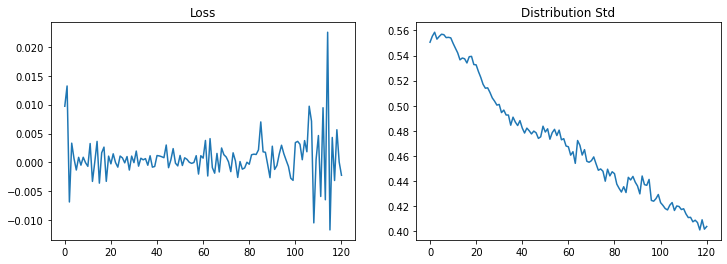

In [9]:
# plot loss and mean standard deviations of actions
fix, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(trainer.metrics['loss'])
axs[0].set_title('Loss')
axs[1].plot(trainer.metrics['std'])
axs[1].set_title('Distribution Std')

### Evaluation

In [15]:
# evaluate the agent by playing some episodes
for i in range(5):
    score, length = play_episode(env, brain_name, agent, trainer=None, max_t=1000)
    print('Evaluation score: {}\tepisode length: {}'.format(score, length))

Evaluation score: 1.1900000181049109	episode length: 444
Evaluation score: 0.30000000447034836	episode length: 101
Evaluation score: 0.4000000059604645	episode length: 143
Evaluation score: 0.20000000298023224	episode length: 70
Evaluation score: 2.600000038743019	episode length: 999


### Shutdown
Shutdown the environment by running the following cell.

In [ ]:
env.close()